In [24]:
import jax
import jax.numpy as jnp
from tqdm import tqdm 
import pandas as pd
import wandb
#import argparse
import scipy
import pickle 
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.backends.backend_pdf as backend_pdf
import subprocess
import time
import glob 

from bridge_sampling.BFFG import backward_filter, forward_guide, forward_guide_edge, get_logpsi
from bridge_sampling.setup_SDEs import Stratonovich_to_Ito, dtsdWsT, dWs
from bridge_sampling.noise_kernel import Q12
from bridge_sampling.helper_functions import *

from mcmc import *
import subprocess
import time

In [25]:
def run_mcmc_for_all_datasets(experiment_path, 
                              num_chains=3, 
                              num_samples=5, 
                              dt=0.05, 
                              lambd=0.98, 
                              obs_var=0.001, 
                              rb=1, 
                              prior_sigma_min=0.1, 
                              prior_sigma_max=1.0, 
                              prior_alpha_min=0.00001, 
                              prior_alpha_max=0.01, 
                              proposal_sigma_tau=0.002, 
                              proposal_alpha_tau=0.002):
    """Run MCMC for all datasets in the experiment path"""

    
    # Get all dataset folders
    dataset_folders = glob.glob(f"{experiment_path}/seed=*")
    
    print(f"Found {len(dataset_folders)} datasets in {experiment_path}")
    
    # Loop through each dataset folder
    for dataset_folder in dataset_folders:
        # Extract the folder name
        folder_name = os.path.basename(dataset_folder)
        print(f"\nProcessing dataset: {folder_name}")
        
        # Check if the required file exists
        data_file = f"{dataset_folder}/procrustes_aligned.csv"
        if not os.path.exists(data_file):
            print(f"  Skipping: {data_file} not found")
            continue
        
        # Generate a random seed for this batch of chains
        seed_start = np.random.randint(0, 1000_000_000)
        
        # Set up output path
        output_path = f"{dataset_folder}/mcmc_seed={seed_start}_N={num_samples}"
        
        print(f"  Starting {num_chains} MCMC chains with seed {seed_start}")
        
        # Start MCMC chains in screen sessions
        screen_sessions = run_mcmc_in_screens(
            num_chains=num_chains,
            script_path="run_mcmc.py",
            seed_param="--seed_mcmc",
            seed_start=seed_start,
            screen_prefix=f"mcmc_{folder_name}",  # Use unique screen names
            script_args={
                "--outputpath": output_path,
                "--phylopath": "../data/chazot_subtree_rounded.nw",
                "--datapath": data_file,
                "--dt": dt,
                "--lambd": lambd,
                "--obs_var": obs_var,
                "--rb": rb,
                "--N": num_samples,
                "--prior_sigma_min": prior_sigma_min,
                "--prior_sigma_max": prior_sigma_max,
                "--prior_alpha_min": prior_alpha_min,
                "--prior_alpha_max": prior_alpha_max,
                "--proposal_sigma_tau": proposal_sigma_tau,
                "--proposal_alpha_tau": proposal_alpha_tau,
                "--use_wandb": True
            }
        )
        
        print(f"  Started chains for {folder_name}. Screen sessions: {', '.join(screen_sessions)}")
        
        # Optional: Add a delay between datasets to avoid overloading the system
        time.sleep(5)
    
    print(f"\nMCMC chains started for all datasets in {experiment_path}")



In [ ]:
# MCMC settings
num_chains = 3
num_samples = 3000
dt = 0.05
lambd = 0.95
obs_var = 0.001
rb = 1
prior_sigma_min = 0.0
prior_sigma_max = 0.2
prior_alpha_min = 0.0
prior_alpha_max = 0.01
proposal_sigma_tau = 0.002
proposal_alpha_tau = 0.002
seed_start = np.random.randint(0,1000_000_000)

In [27]:
# Run the function
experiment_path = "exp_1_sigma=0.7_alpha=0.025_dt=0.05"
run_mcmc_for_all_datasets(experiment_path=experiment_path,
                          num_chains=num_chains,
                          num_samples=num_samples,
                          dt=dt,
                          lambd=lambd,
                          obs_var=obs_var,
                          rb=rb,
                          prior_sigma_min=prior_sigma_min,
                          prior_sigma_max=prior_sigma_max,
                          prior_alpha_min=prior_alpha_min,
                          prior_alpha_max=prior_alpha_max,
                          proposal_sigma_tau=proposal_sigma_tau,
                          proposal_alpha_tau=proposal_alpha_tau)    

Found 2 datasets in exp_1_sigma=0.7_alpha=0.025_dt=0.05

Processing dataset: seed=121197884
  Starting 1 MCMC chains with seed 337323040
Starting chain 1 with seed 337323040 in screen 'mcmc_seed=121197884_1'

1 MCMC chains started in separate screen sessions.
To attach to a screen session: screen -r <screen_name>
To detach from a screen session: Ctrl+A, then D
Screen sessions: mcmc_seed=121197884_1
  Started chains for seed=121197884. Screen sessions: mcmc_seed=121197884_1

Processing dataset: seed=1106754318
  Starting 1 MCMC chains with seed 163492372
Starting chain 1 with seed 163492372 in screen 'mcmc_seed=1106754318_1'

1 MCMC chains started in separate screen sessions.
To attach to a screen session: screen -r <screen_name>
To detach from a screen session: Ctrl+A, then D
Screen sessions: mcmc_seed=1106754318_1
  Started chains for seed=1106754318. Screen sessions: mcmc_seed=1106754318_1

MCMC chains started for all datasets in exp_1_sigma=0.7_alpha=0.025_dt=0.05


In [ ]:
experiment_path = "comparison/exp_1_sigma=0.7_alpha=0.025_dt=0.05"

# Visualize results 

In [11]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

def load_mcmc_results(filepath_pattern):
    """
    Load MCMC results from pickle files matching the given pattern.
    
    Args:
        filepath_pattern: Pattern to match pickle files (e.g., "results/chain_*.pkl")
        
    Returns:
        List of loaded results
    """
    results = []
    for filepath in sorted(glob.glob(filepath_pattern)):
        print(f"Loading {filepath}")
        with open(filepath, 'rb') as f:
            results.append(pickle.load(f))
    return results

In [19]:
results_path = "exp_1_sigma=0.7_alpha=0.025_dt=0.05/seed=121197884/mcmc_seed=871636495_N=3000/results_*.pkl"  # Adjust pattern as needed
chain_results = load_mcmc_results(results_path)
param_names = ["sigmas", "alphas"]  # Replace with your actual parameter names
len(chain_results)

Loading exp_1_sigma=0.7_alpha=0.025_dt=0.05/seed=121197884/mcmc_seed=871636495_N=3000/results_chain=871636495.pkl


1

In [20]:
chain_results[0]['acceptpath']

array([1., 1., 1., ..., 1., 1., 0.], shape=(3001,))

In [21]:
[np.mean(result['acceptpath']) for result in chain_results if result is not None]

[np.float64(0.9883372209263579)]

[[<matplotlib.lines.Line2D at 0x15ea8c7d0>]]

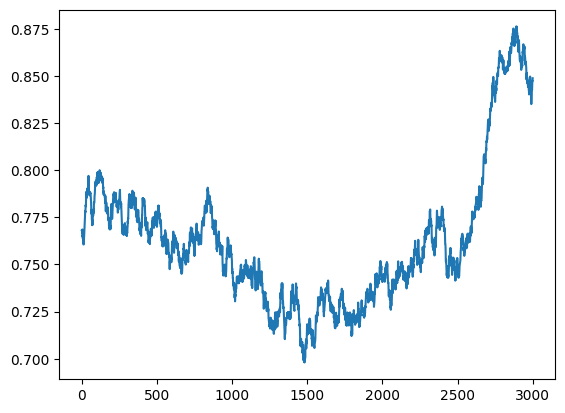

In [22]:
[plt.plot(chain_results[i]['sigmas']) for i in range(len(chain_results))]

[[<matplotlib.lines.Line2D at 0x105222fd0>]]

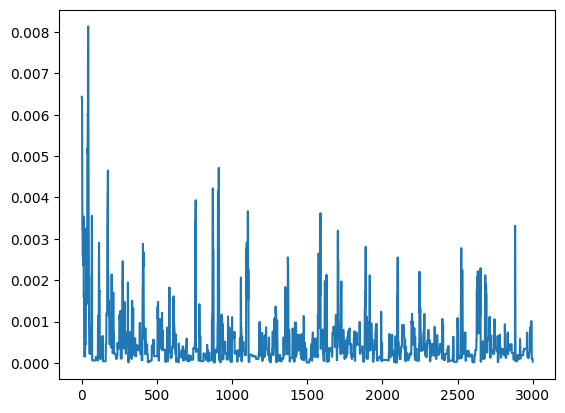

In [23]:
[plt.plot(chain_results[i]['alphas']) for i in range(len(chain_results))]